In [81]:
import pandas as pd
from sklearn.preprocessing import *
from sklearn_pandas import DataFrameMapper
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import re
import math
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_full = pd.concat([df_train, df_test], axis = 0)

First of all, we examine the dataset for missing values. We print out each column to get a feel for the incompleteness of the data.

In [82]:
print('Missing values per column:')
missing = pd.DataFrame()
for c in range(df_full.shape[1]):
    missing_count = df_full.iloc[:, c].shape[0] - df_full.iloc[:, c].count()  
    if missing_count > 0:
        missing[df_full.columns[c]] = (missing_count, len(pd.value_counts(df_full.iloc[:, c])))
for name, m_count, u_count in missing.items():
        print(f'{c}:\t{name}'
              f' - Missing: {m_count}'
              f' - # Unique values: {u_count}')

Missing values per column:
3:	Alley - Missing: 2721 - # Unique values: 2
6:	BsmtCond - Missing: 82 - # Unique values: 4
7:	BsmtExposure - Missing: 82 - # Unique values: 4
8:	BsmtFinSF1 - Missing: 1 - # Unique values: 991
9:	BsmtFinSF2 - Missing: 1 - # Unique values: 272
10:	BsmtFinType1 - Missing: 79 - # Unique values: 6
11:	BsmtFinType2 - Missing: 80 - # Unique values: 6
12:	BsmtFullBath - Missing: 2 - # Unique values: 4
13:	BsmtHalfBath - Missing: 2 - # Unique values: 3
14:	BsmtQual - Missing: 81 - # Unique values: 4
15:	BsmtUnfSF - Missing: 1 - # Unique values: 1135
19:	Electrical - Missing: 1 - # Unique values: 5
23:	Exterior1st - Missing: 1 - # Unique values: 15
24:	Exterior2nd - Missing: 1 - # Unique values: 16
25:	Fence - Missing: 2348 - # Unique values: 4
26:	FireplaceQu - Missing: 1420 - # Unique values: 5
30:	Functional - Missing: 2 - # Unique values: 7
31:	GarageArea - Missing: 1 - # Unique values: 603
32:	GarageCars - Missing: 1 - # Unique values: 6
33:	GarageCond - Missing

There exists a lot of missing values. However, reading the data description, it's clear that the data is very clean and that the missing values are real values not incomplete data. We replace all np.nan values with a placeholder below. The placeholder is 'None' for discrete features or zero for continuous features. We also store the names of continuous and discrete features in order to plot thom.

In [83]:
missing_label = 'None'
cont_feature = []
disc_feature = []
for c in range(df_full.shape[1]):
    if len(pd.value_counts(df_full.iloc[:, c])) > 8 and df_full.iloc[:, c].values.dtype != 'object':
        if df_full.columns[c] not in ('SalePrice', 'Id'):
            df_full.iloc[:, c].fillna(0, inplace = True)
            cont_feature.append(df_full.columns[c])
    else:
        df_full.iloc[:, c].fillna(missing_label, inplace = True)
        disc_feature.append(df_full.columns[c])

We then visualize the relation between each continuous feature and the target variable in order to get a better feel for the data.

/home/mmaesawy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


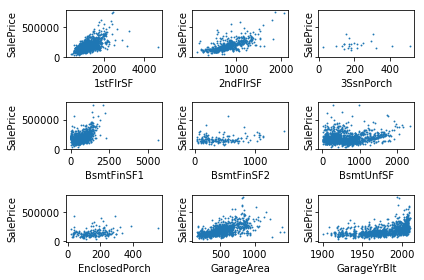

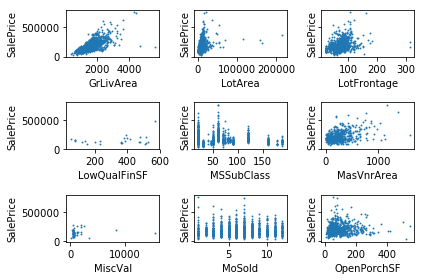

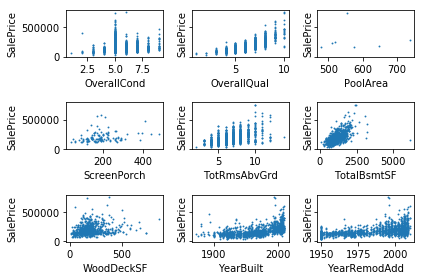

In [84]:
plt.ion()
i = 0
while i < len(cont_feature):
    fig, axs = plt.subplots(nrows = 3,
                            ncols= 3,
                            sharey = 'row')
    axs = axs.flatten()
    for ax in axs:
        if i >= len(cont_feature): break
        not_na_mask = [x != 0 for x in df_full[cont_feature[i]]]
        ax.scatter(x = df_full[cont_feature[i]].loc[not_na_mask],
                   y = df_full['SalePrice'].loc[not_na_mask],
                   s = 3, marker = '.')
        ax.set_xlabel(cont_feature[i])
        ax.set_ylabel('SalePrice')
        i += 1
    fig.tight_layout()
    fig.show()

We can see from the graphs that most continuous features can be well approximated by a linear or polynomial function. We do the same for discrete features, plotting them in box plots to get a better feel for the data. In addition, we convert the labels to numeric ordinal values. In addition, we move the MoSold and MSSubClass features to the discrete columns to sort them into ordinal values.

/home/mmaesawy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


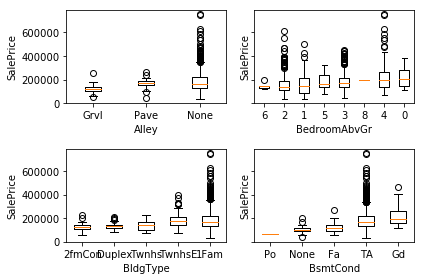

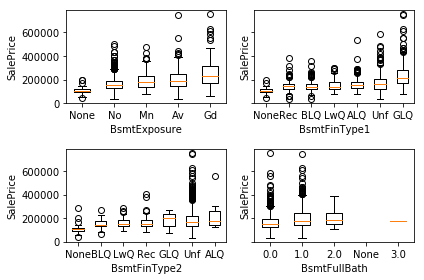

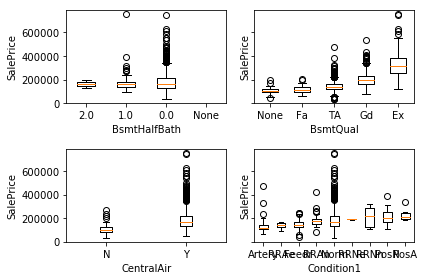

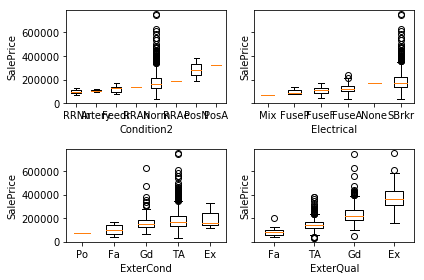

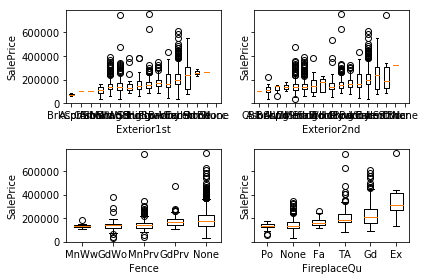

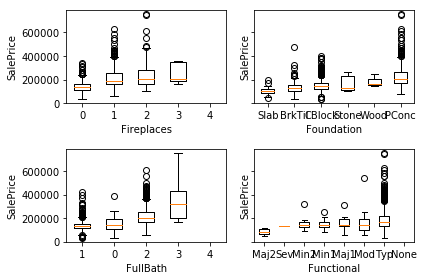

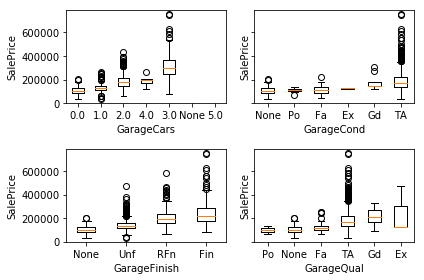

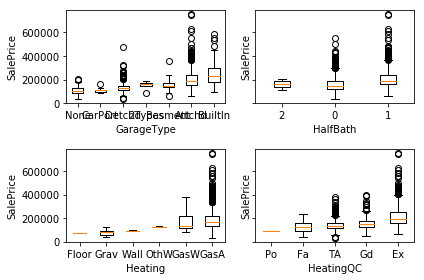

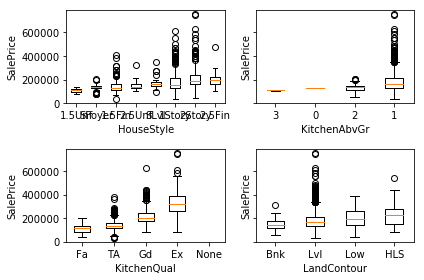

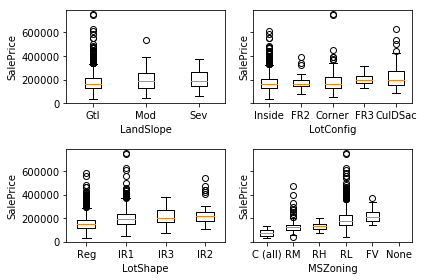

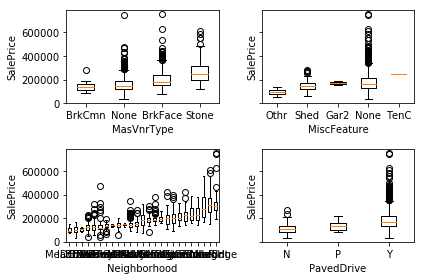

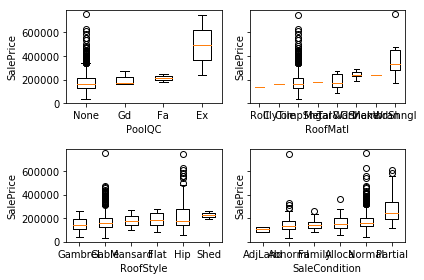

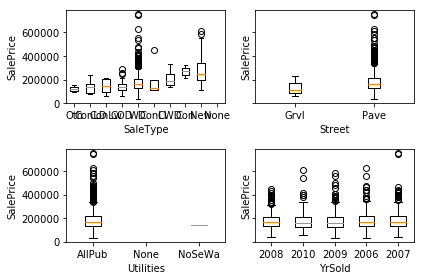

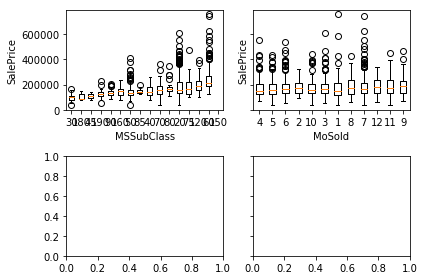

In [85]:
cont_feature.remove('MSSubClass')
cont_feature.remove('MoSold')
disc_feature.append('MSSubClass')
disc_feature.append('MoSold')
i = 0
while i < len(disc_feature):
    fig, axs = plt.subplots(nrows = 2,
                            ncols= 2,
                            sharey = 'row')
    axs = axs.flatten()
    for ax in axs:
        if i >= len(disc_feature): break
        categories = df_full[disc_feature[i]].value_counts().index.tolist()
        categories.sort(key = lambda x: df_full['SalePrice'][df_full[disc_feature[i]] == x].mean())
        t = df_full.iloc[:df_train.shape[0], :]
        boxes = [t['SalePrice'][t[disc_feature[i]] == category] for category in categories]
        ax.boxplot(boxes, labels=categories)
        ax.set_xlabel(disc_feature[i])
        ax.set_ylabel('SalePrice')
        
        # Transforming labels into ordinal values sorted according to mean (from above).
        categories = dict(zip(categories, range(len(categories))))
        df_full[disc_feature[i]] = df_full[disc_feature[i]].apply(lambda x: categories[x])
        i += 1
        
    fig.tight_layout()
    fig.show()

Once again, it appears that most features can be modelled with a polynomial function. We can conclude that a linear model will do well on this data, but we'll try different methods as well just to be sure. Next, we standardize the data and plot a PCA scree plot to hopefully reduce the data's dimensionality.

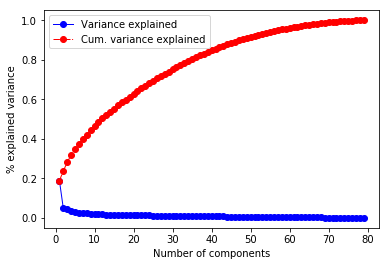

In [86]:
random_seed = 4057585448 # Random seed for reproducibility.

df_train = df_full.iloc[:df_train.shape[0], :]
df_test = df_full.iloc[df_train.shape[0]+1:, :]

X_train = df_train[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train['SalePrice'].values
X_test = df_test[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

for i in range(X_train.shape[1]):
    le = LabelEncoder()
    X_train[:, i] = le.fit_transform(X_train[:, i])

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(random_state = random_seed)
pca.fit(X_train)

plt.plot(range(1, X_train.shape[1] + 1),
         pca.explained_variance_ratio_,
         lw=1, color='blue',
         label='Variance explained',
         marker = 'o')
plt.plot(range(1, X_train.shape[1] + 1),
         np.cumsum(pca.explained_variance_ratio_),
         lw=1, color='red',
         ls='-.', marker = 'o',
         label='Cum. variance explained')
plt.xlabel('Number of components')
plt.ylabel('% explained variance')
plt.legend(loc = 'upper left')
plt.show()

<p>Due to the smoothness of the scree plot, we cannot project the data into a lower dimension. We will use the full dataset to train our model. Interestingly, a relatively large amount of variance is explained by the first component, however it does not explain enough variance to be useful on its own.</p>
<p>We then do a gridsearch over various models, testing various hyperparameters to get the best model representing our data.</p>

In [89]:
print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=GradientBoostingRegressor(),
                      param_grid=[{'learning_rate': [x / 100 for x in range(5, 15, 1)],
                                   'max_depth': [x for x in range(2, 5)],
                                   'max_features': [x / 10 for x in range(7, 11)]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {(-gb_gs.best_score_)**.5}')
print(gb_gs.best_params_)
print()

print("Grid searching bagging model...")
bag_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=BaggingRegressor(base_estimator = LinearRegression(),
                                                 n_estimators = 25),
                      param_grid=[{'max_features': [x / 100 for x in range(50, 101, 1)]}])
bag_gs.fit(X_train, y_train)
print(f'Best score is {(-bag_gs.best_score_)**.5}')
print(bag_gs.best_params_)
print()

print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x for x in range(1, 1000, 10)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {(-lasso_gs.best_score_)**.5}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x for x in range(0, 1000, 10)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {(-ridge_gs.best_score_)**.5}')
print(ridge_gs.best_params_)
print()

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {(-rf_gs.best_score_)**.5}')
print(rf_gs.best_params_)

print("Grid searching KNN model... ")
knn_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1,
                      estimator=KNeighborsRegressor(),
                      param_grid=[{'n_neighbors': [x for x in range(3, 80)],
                                   'weights': ['uniform', 'distance']}])
knn_gs.fit(X_train, y_train)
print(f'Best score is {(-knn_gs.best_score_)**.5}')
print(knn_gs.best_params_)

Grid searching GB model...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.8s


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.2min finished


Best score is 24541.79915191228
{'learning_rate': 0.11, 'max_depth': 3, 'max_features': 0.7}

Grid searching bagging model...
Fitting 10 folds for each of 51 candidates, totalling 510 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s


KeyboardInterrupt: 